# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 2. Define the Architecture of the Policy

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        # return selected action and its prob
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [3]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        # sum of the reward for each action in the episose multiply by discount factor
        R = sum([a*b for a,b in zip(discounts, rewards)]) 
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

tensor(209.5441)
tensor(93.6731)
tensor(63.2887)
tensor(216.2443)
tensor(567.6891)
tensor(169.2275)
tensor(312.2610)
tensor(2083.3674)
tensor(308.6760)
tensor(424.0987)
tensor(337.3022)
tensor(73.7557)
tensor(222.7805)
tensor(171.7534)
tensor(1504.7108)
tensor(221.5844)
tensor(2586.3220)
tensor(703.6938)
tensor(298.7545)
tensor(1509.9144)
tensor(80.7796)
tensor(2630.6643)
tensor(10049.2246)
tensor(327.2238)
tensor(159.4588)
tensor(308.5422)
tensor(434.4589)
tensor(430.8561)
tensor(964.2853)
tensor(137.3669)
tensor(1235.0306)
tensor(238.6528)
tensor(1139.6342)
tensor(1345.2017)
tensor(419.5891)
tensor(212.9684)
tensor(331.5077)
tensor(272.9570)
tensor(168.0135)
tensor(2627.9307)
tensor(6162.5703)
tensor(439.8737)
tensor(1041.2670)
tensor(176.0688)
tensor(152.7368)
tensor(757.4540)
tensor(85.3063)
tensor(61.0860)
tensor(278.3154)
tensor(166.4535)
tensor(222.3943)
tensor(243.0195)
tensor(1475.2561)
tensor(64.7311)
tensor(966.0440)
tensor(248.2190)
tensor(188.9793)
tensor(1389.2123)
tensor

tensor(23715.1621)
tensor(23609.0781)
tensor(21613.2051)
tensor(22105.6113)
tensor(20878.1934)
tensor(22592.3105)
tensor(20713.4258)
tensor(21758.4629)
tensor(21117.4375)
tensor(21410.0820)
tensor(22556.3418)
tensor(21028.2109)
tensor(21136.9336)
tensor(21706.3887)
tensor(22420.2344)
tensor(22867.7910)
tensor(24009.5957)
tensor(21433.3223)
tensor(21989.8008)
tensor(15024.0078)
tensor(23545.8691)
tensor(22406.6426)
tensor(22328.0820)
tensor(21722.2246)
tensor(24136.6797)
tensor(22741.9629)
tensor(22811.5723)
tensor(23153.5859)
tensor(23463.7617)
tensor(23789.4121)
tensor(23218.4102)
tensor(22839.3145)
tensor(23477.1289)
tensor(23183.3906)
tensor(23490.6855)
tensor(15865.6611)
tensor(23037.8301)
tensor(24682.9160)
tensor(16672.9805)
tensor(23421.8535)
tensor(23034.5664)
tensor(3307.8838)
tensor(23212.5215)
tensor(23159.2793)
tensor(6150.4844)
tensor(1649.2806)
tensor(23551.0957)
tensor(22984.2109)
Episode 500	Average Score: 172.00
tensor(23310.9082)
tensor(22776.6289)
tensor(22245.4316)


### 4. Plot the Scores

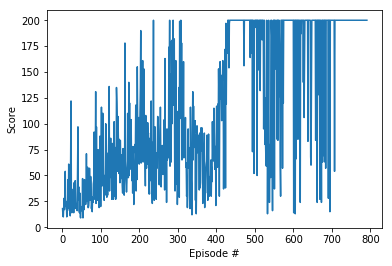

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

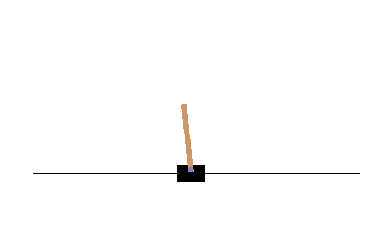

In [5]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()